In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, scale, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from scipy.stats import ttest_rel
from datetime import datetime

from numpy import logspace, random, isnan
import pickle
from scipy.stats import rankdata
from os.path import basename, join
from os import mkdir 

from json import dumps 

import shap
from copy import deepcopy

from sklearn.ensemble import RandomForestRegressor
import TraitData
from imp import reload
import seaborn as sns

## Set Parameters for Analysis 

# Plotting
sns.set()
sns.set(font_scale=1.5)
%matplotlib inline
plt.rcParams['figure.figsize'] = (7,15)
%config InlineBackend.figure_format = 'retina'

# 10-Fold Cross Validator
cv = KFold(n_splits=10)

# Load saved Random State to ensure replicablility.
try:
    SAVED_STATE = pickle.load(open("np.random.state", 'rb'))
    np.random.set_state(SAVED_STATE)
except Exception as e:
    SAVED_STATE = False
    

<img style="float:right" src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" width=60px)/>
<h1> Nonlinear Modeling of Trait-Range Shift Relationships <small> by: Tony Cannistra </small></h1>

We are attempting to understand the type and magnitude of the effects that various physiological or behavioral traits have had on historical range shifts.

The challenge is that standard linear regression has been only able to explain a small percentage of the variance seen in range shift data for several taxa ([Angert et al., 2011](http://onlinelibrary.wiley.com/doi/10.1111/j.1461-0248.2011.01620.x/abstract)). This is likely as a result of the relationships between predictor and response variables being something other than linear, especially since several variables have biological relevance for their ability to facilitate range shifts. 

## Load Data + Define Functions
For this exploration we have trait data for several large taxonomic groups of organisms and their observed range shifts over the past 100 years. There are 3 datasets
### Define Each Dataset

In [2]:
plantsData = {
    'name' : "European Plants",
    'file' : "../data/angert_etal_2011/plants5.csv",
    
    'responseVar'   : "migration_m",

    'drop_features' : ["Taxon",
                     "migr_sterr_m", 
                     "shift + 2SE", 
                     'signif_shift',
                     "signif_shift2",
                     "dispmode01",
                     "DispModeEng", ## what is this
                     "shift + 2SE", 
                      "Grime"],
    'categorical_features' : ["oceanity",
                            "dispersal_mode",
                            "BreedSysCode", "SI01"], 
    
    'traits_desc_file' : "../data/angert_etal_2011/traits-desc-plants.csv"
}

plantsData_extendedDrop = deepcopy(plantsData)
plantsData_extendedDrop['name'] = "Swiss Alpine Plants"
plantsData_extendedDrop.get('drop_features').extend(["Bio1_mean_nosyn",
                                                 "Bio1_std_nosyn",
                                                 "Bio1_var_nosyn", 
                                                 "Bio1_mean_inclsyn",
                                                 "Bio1_std_inclsyn",
                                                 "Bio1_var_inclsyn"])

mammalData = {
    'name' : "Mammals - Full",
    'file' : "../data/angert_etal_2011/mammals01.csv",
    
    'responseVar'   : "High_change",

    'drop_features' : ["Taxon",
                       "High_change_pfa2",
                       "Daily_rhythm_code",
                       "Annual_rhythm_code"],
    
    'categorical_features' : ["Daily01",
                              "Annual01",
                              "Food01",
                              "Daily_rhythm",
                              "Annual_rhythm",
                              "Food"],
    
    'traits_desc_file' : "../data/angert_etal_2011/traits-desc-mammals.csv"
}

mammalData_extendedDrop = deepcopy(mammalData)
mammalData_extendedDrop['name'] = "Mammals"
mammalData_extendedDrop.get("drop_features").extend(["Bio1_mean",
                                                     "Daily01_0",
                                                     "Daily01_1",
                                                     "Annual01_0",
                                                     "Annual01_1",
                                                     "Food01_0",
                                                     "Food01_1"])

triennialMarineData = {
    'name' : "Triennial Marine Survey -- Full",
    'file' : "../data/marine/west-coast-triennial _species_generaltraits.csv",
    'responseVar' : "Latitudinal Difference",
    
    'drop_features' : ["Species", "Latitudinal Std",
                      "FamCode", "GenCode"], 
    
    'categorical_features' : [
        "UsedforAquaculture",
        "Electrogenic",
        "DemersPelag",
        "LTypeMaxM", 
        "Fresh", 
        "Brack", 
        "Saltwater"
    ], 
    
    'traits_desc_file' : "../data/marine/traits-desc.csv"
}

triennialMarineData_extendedDrop = deepcopy(triennialMarineData)
triennialMarineData_extendedDrop['name'] = "Triennial Marine Survey"
triennialMarineData_extendedDrop.get("drop_features").extend(["Electrogenic_Electrosensing only",
                                                              "Electrogenic_electrosensing only",
                                                              "Electrogenic_no special ability",
                                                              "Electrogenic_strongly discharging",
                                                              "Electrogenic_weakly discharging",
                                                              "LTypeMaxM_FL","LTypeMaxM_SL", "LTypeMaxM_TL"])


TRYdata = {
    'name': "European Plants",
    'file': "../data/TRY/rumpf_ShiftsTraitsBuckley_20180418.csv",
    'responseVar' : "LeadingEdge", # there's also "RearEdge" and "Optimum"
    'drop_features' : ['speciesname',
                       'Dispersal',
                       'Persistence', 
                       'RearEdge', 
                       'Optimum'],
    'categorical_features': ['LifeStrategy']
}


datasets = {
    plantsData_extendedDrop['name'] : plantsData_extendedDrop,
    mammalData_extendedDrop['name'] : mammalData_extendedDrop,
    triennialMarineData_extendedDrop['name'] : triennialMarineData_extendedDrop,
    TRYdata['name'] : TRYdata
}
with open("DATA_SPECIFICATION.json", 'w') as dsjson:
    dsjson.write(dumps(list(d for k, d in datasets.items())))
                
all_mses = {}
rankings = []
MSEs = []
COEFs = []

print(", ".join(datasets.keys()))
print("filenames: {}".format(", ".join(d['name'].replace(" ", '-') for k, d in datasets.items())))


Swiss Alpine Plants, European Plants, Triennial Marine Survey, Mammals
filenames: Swiss-Alpine-Plants, European-Plants, Triennial-Marine-Survey, Mammals


---
### Select, Load, and Normalize Dataset

This notebook **needs to be run once per dataset**. Below we select which dataset will be run through the notebook.

In [3]:
# Select Dataset
dataset = datasets['Swiss Alpine Plants']
dsname = dataset['name'].replace(" ", "-")
runtime = datetime.now().strftime("%Y-%m-%d_%X")

# create results directory 
results_dir = '-'.join([dsname, runtime])
mkdir(results_dir)

# Drop: Rows with any NAs (0), Columns with any NAs (1), or nothing (None)
dropNA  = 0

td = TraitData.TraitData(dataset['file'],
                         dataset['responseVar'],
                         dataset['drop_features'],
                         dataset['categorical_features'],
                         dropNA=dropNA, scale=True)

## rename traits using traits_desc_file, defined above
try: 
    traitnames = pd.read_csv(dataset['traits_desc_file']).fillna('')
    traitnames_map = { a:b for a, b in zip(traitnames.name, traitnames.description)}
    td.feature_names = [traitnames_map[trait] if traitnames_map[trait] != '' else trait for trait in td.feature_names]
    td.X.columns = td.feature_names
except: 
    print("No trait description.")
    
print(len(td.X))
display(td.X.head())
td.X = np.array(td.X)
td.Y = np.array(td.Y)

print(td.X.shape)
print("\n".join(td.feature_names))





No trait description.
20


/Users/tony/miniconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


,StorageOrgan,ReprModeCode,flwr_mo_start,flwr_mo_end,flwr_dur_mos,earliest_seed_shed_mo,latest_seed_shed_mo,seed_shed_dur_mos,seed_mass_mg,diaspore_mass_mg,...,dispersal_mode_animal,dispersal_mode_gravity,dispersal_mode_water,dispersal_mode_wind,BreedSysCode_1.0,BreedSysCode_2.0,BreedSysCode_3.0,BreedSysCode_4.0,SI01_0.0,SI01_1.0
0,-1.224745,1.0,0.680746,1.171700,-0.043073,1.242260,0.870936,-0.664411,-0.176321,-0.210020,...,-0.333333,0.816497,0.0,-0.577350,1,0,0,0,0,1
3,-1.224745,1.0,0.680746,1.171700,-0.043073,0.745356,0.358621,-0.664411,-0.555505,-0.593620,...,-0.333333,-1.224745,0.0,1.732051,1,0,0,0,0,1
11,0.816497,-1.0,0.680746,-0.130189,-0.904534,-1.739164,-0.153695,1.233905,-0.290076,-0.325100,...,-0.333333,0.816497,0.0,-0.577350,0,0,0,1,1,0
21,0.816497,-1.0,0.680746,-0.130189,-0.904534,1.242260,-0.153695,-1.613569,-0.479668,-0.612799,...,-0.333333,0.816497,0.0,-0.577350,1,0,0,0,0,1
33,0.816497,-1.0,0.680746,-0.130189,-0.904534,0.745356,-0.153695,-1.138990,3.805117,3.817769,...,3.000000,-1.224745,0.0,-0.577350,0,0,1,0,1,0


(20, 38)
StorageOrgan
ReprModeCode
flwr_mo_start
flwr_mo_end
flwr_dur_mos
earliest_seed_shed_mo
latest_seed_shed_mo
seed_shed_dur_mos
seed_mass_mg
diaspore_mass_mg
diaspore_min_len_mm
diaspore_max_len_mm
diaspore_ave_len_mm
Min_seed_shed_ht_m
Max_seed_shed_ht_m
Ave_seed_shed_ht_m
nichebreadth_num_flor_zones
nichebreadth_amplit_ocean
Nbound_lat_GBIF_nosyn
GenTime
Resil
MaxAlt
oceanity_ks
oceanity_o
oceanity_os
oceanity_sks
oceanity_so
oceanity_sos
dispersal_mode_animal
dispersal_mode_gravity
dispersal_mode_water
dispersal_mode_wind
BreedSysCode_1.0
BreedSysCode_2.0
BreedSysCode_3.0
BreedSysCode_4.0
SI01_0.0
SI01_1.0


In [4]:
try:
    print(traitnames.description)
except:
    pass

0                             Storage Organ Presence
1                                                   
2                            Flowering Start (month)
3                              Flowering End (month)
4                        Flowering Duration (months)
5                         Seed Shed Month (earliest)
6                           Seed Shed Month (latest)
7                        Seed Shed Duration (months)
8                             Self Compatibility: No
9                            Self Compatibility: Yes
10                                    Seed Mass (mg)
11                                Diaspore Mass (mg)
12                      Diaspore Minimum Length (mm)
13                      Average Seed Shed Height (m)
14                      Average Diaspore Length (mm)
15                      Minimum Seed Shed Height (m)
16                      Maximum Seed Shed Height (m)
17                      Average Seed Shed Height (M)
18                   Total Number of Floristic

In [5]:
pickle.dump(np.random.get_state(), open('np.random.state', 'wb'), )


## Learning

In [6]:
## Importance Plotting Function
def plot_importance(importances, names, title=None, std=None, ft="", save=None):
    sns.set()
    sns.set(font_scale=1.5)
    plt.rcParams['figure.figsize'] = (7,15)
    f, ax = plt.subplots()
    
    bar_indices = np.arange(len(names))
    bar_width = 0.45
    importances_ind = np.argsort(abs(importances))

    plt.barh(bar_indices,
             importances[importances_ind],
            align='center', color='#4b2e83', xerr=std)
    
    plt.figtext(1, 0, ft, ha='right')
    plt.yticks(bar_indices, np.array(names)[importances_ind])
    plt.title(title)
    plt.tight_layout()
    if(save is not None):
        plt.savefig(save, bbox='tight', dpi=200)
    plt.show()
    
def compute_ranks(importances, absolute=True):
    if absolute:
        sorted_idx =  abs(importances).argsort()[::-1]
    else:
        sorted_idx = importances.argsort()[::-1]
    return(np.arange(len(importances))[sorted_idx.argsort()])

### Linear Models
#### OLS

Err (mean): 5.680487772667076 Err (std.dev): 4.558695533370027


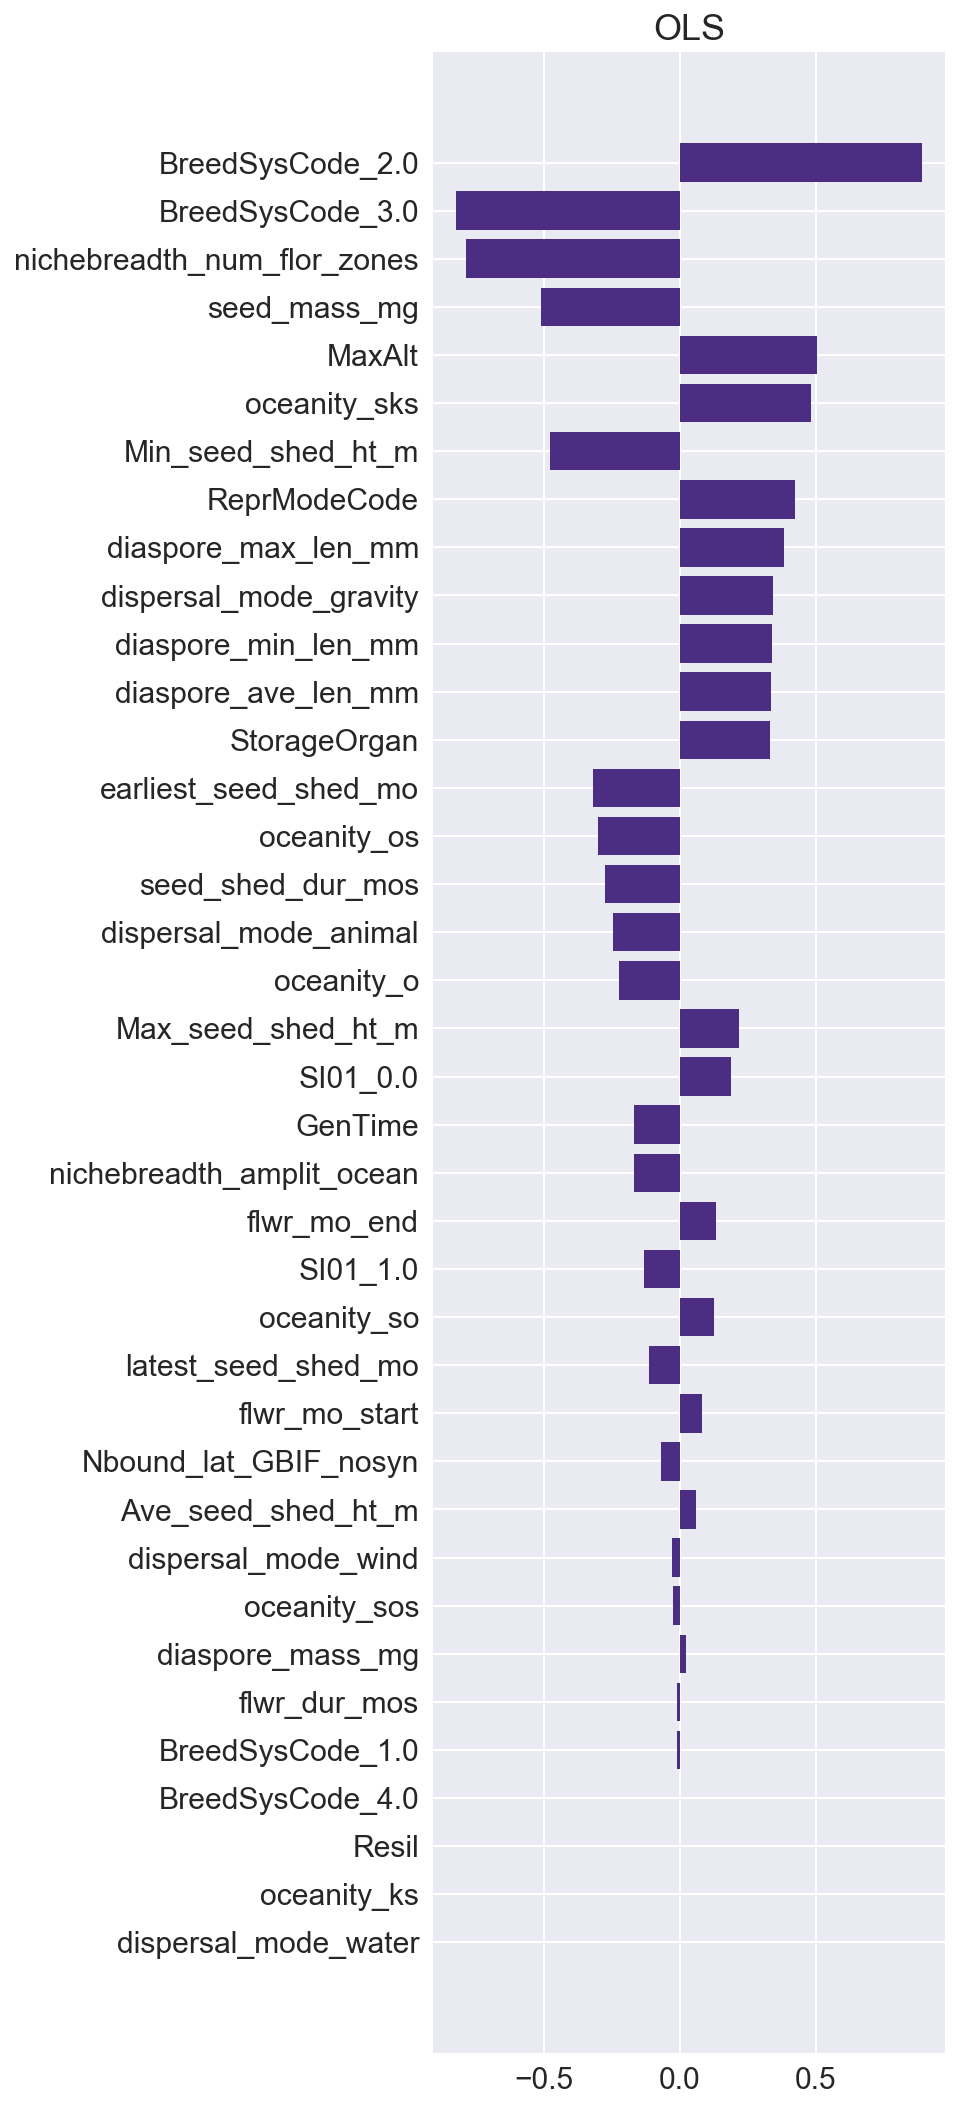

In [7]:
ols_coefs = []
ols_mses = []
for train, test in cv.split(td.X, td.Y):
#     print("#Train: {:d} #Test: {:d}".format(len(train), len(test)))
    ols = LinearRegression(fit_intercept=False, normalize=False)
    ols.fit(td.X[train], td.Y[train])
    preds = ols.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    ols_mses.append(error)
    ols_coefs.append(ols.coef_)

    
mean_error = np.mean(ols_mses)
std_error = np.std(ols_mses)
mean_coefs = np.mean(ols_coefs, axis=0)
std_coefs = np.std(ols_coefs, axis=0)
print("Err (mean): {} Err (std.dev): {}".format(mean_error, std_error))

plot_importance(mean_coefs,
                td.feature_names, "OLS",
                save="{}_ols-ranks.png".format(join(results_dir, dsname)))#, std=std_coefs)
MSEs.append(("OLS", ols_mses))
COEFs.append(("OLS", mean_coefs))
rankings.append(['OLS'] + list(compute_ranks(mean_coefs)))


## OLS + Polyfeatures

In [8]:
from sklearn.pipeline import make_pipeline
ols_coefs = []
ols_mses = []
for train, test in cv.split(td.X, td.Y):
#     print("#Train: {:d} #Test: {:d}".format(len(train), len(test)))
    ols = make_pipeline(PolynomialFeatures(2), LinearRegression(fit_intercept=False, normalize=False))
    ols.fit(td.X[train], td.Y[train])
    preds = ols.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    print(error)
    ols_mses.append(error)
    ols_coefs.append(ols.named_steps['linearregression'].coef_)


    
mean_error = np.mean(ols_mses)
std_error = np.std(ols_mses)
mean_coefs = np.mean(ols_coefs, axis=0)
std_coefs = np.std(ols_coefs, axis=0)
print("Err (mean): {} Err (std.dev): {}".format(mean_error, std_error))
print(mean_coefs)

# plot_importance(mean_coefs,
#                 td.feature_names, "OLS",
#                 save="{}_ols-ranks.png".format(join(results_dir, dsname)))#, std=std_coefs)
MSEs.append(("OLS", ols_mses))
COEFs.append(("OLS", mean_coefs))
rankings.append(['OLS'] + list(compute_ranks(mean_coefs)))


0.430197480575
0.0524385503702
5.32164381419
2.81961623526
0.369326876169
1.21374980809
0.687803679376
0.483110920046
2.3588148184
0.486526512122
Err (mean): 1.4223228694608927 Err (std.dev): 1.5602788602782314
[  5.07744885e-03   8.02010643e-03   6.25999265e-03  -8.19502187e-03
  -5.39020258e-03   6.28530033e-03  -2.81475739e-02  -2.80093488e-04
   1.28405918e-02  -1.38198265e-02  -9.42180743e-03  -3.54575739e-03
  -6.90804577e-03  -5.19459316e-03  -1.33037541e-02  -1.58528232e-02
  -1.59609100e-02  -3.17318770e-02  -1.41441773e-02  -1.50802062e-02
   2.05698245e-03   0.00000000e+00  -1.45479277e-02   0.00000000e+00
  -2.48394609e-03  -4.92405921e-03   1.09018537e-04   1.85425946e-02
  -6.16615903e-03  -7.68466643e-03   1.21555674e-02   0.00000000e+00
  -2.83915420e-03   2.66771948e-03   1.72662484e-02  -1.63243555e-02
   1.46783638e-03  -3.68081482e-03   8.75826367e-03   1.80325411e-03
   4.90824998e-03  -3.86570969e-02  -1.36618106e-02   3.74332774e-02
  -5.11189450e-02  -3.47003124

#### Ridge CV

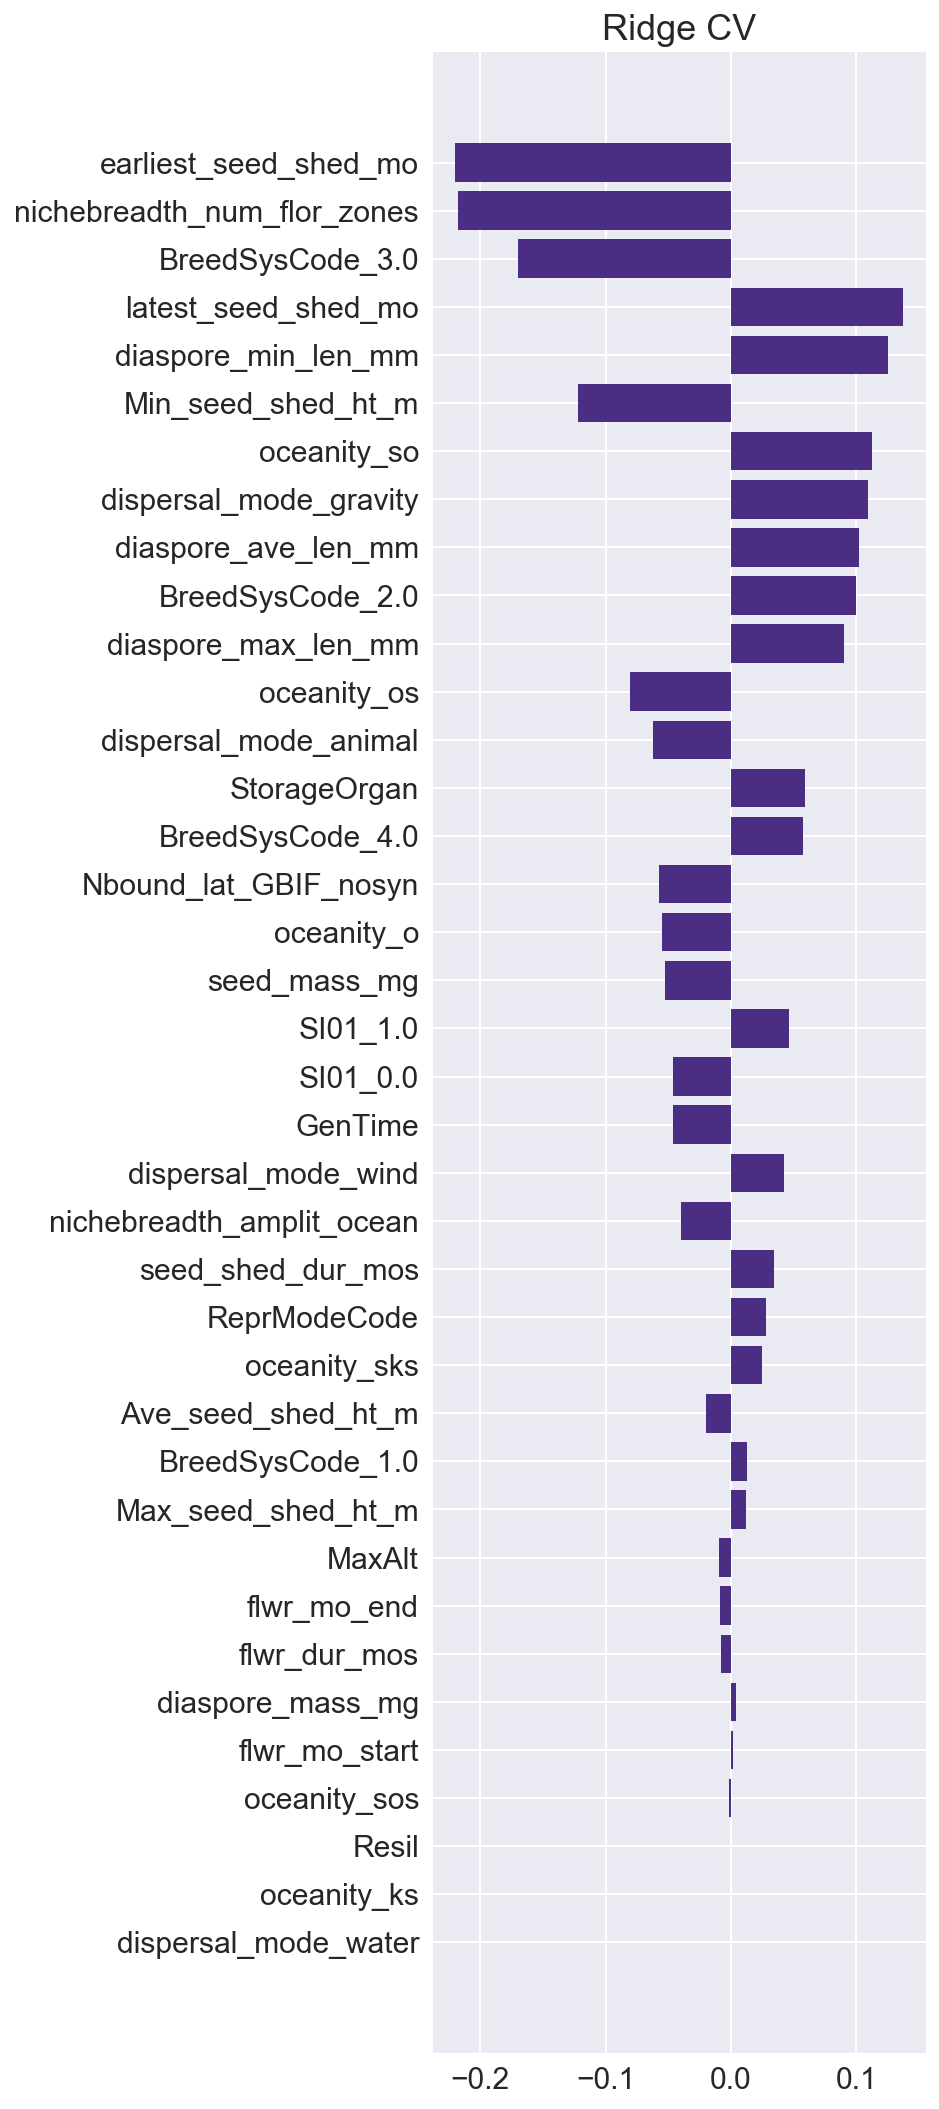

In [9]:
ridge_coefs = []
ridge_mses = []
for train, test in cv.split(td.X, td.Y):
    ridgecv = RidgeCV(normalize=False)
    ridgecv.fit(td.X[train], td.Y[train])
    preds = ridgecv.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    ridge_mses.append(error)
    ridge_coefs.append(ridgecv.coef_)
    
mean_error = np.mean(ridge_mses)
std_error = np.std(ridge_mses)
mean_coefs = np.mean(ridge_coefs, axis=0)
std_coefs = np.std(ridge_coefs, axis=0)

    
plot_importance(mean_coefs, td.feature_names,  "Ridge CV",# std=std_coefs,
               save="{}_ridge-ranks.png".format(join(results_dir, dsname)))
rankings.append(['Ridge'] + list(compute_ranks(mean_coefs)))
MSEs.append(("Ridge", ridge_mses))
COEFs.append(("Ridge", mean_coefs))


#### Ridge Poly

In [10]:
ridge_coefs = []
ridge_mses = []
for train, test in cv.split(td.X, td.Y):
    ridgecv = make_pipeline(PolynomialFeatures(3), RidgeCV(normalize=False))
    ridgecv.fit(td.X[train], td.Y[train])
    preds = ridgecv.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    ridge_mses.append(error)
    ridge_coefs.append(ridgecv.named_steps['ridgecv'].coef_)
    
mean_error = np.mean(ridge_mses)
std_error = np.std(ridge_mses)
mean_coefs = np.mean(ridge_coefs, axis=0)
std_coefs = np.std(ridge_coefs, axis=0)

    
# plot_importance(mean_coefs, td.feature_names,  "Ridge CV",# std=std_coefs,
#                save="{}_ridge-ranks.png".format(join(results_dir, dsname)))
rankings.append(['Ridge Poly'] + list(compute_ranks(mean_coefs)))
MSEs.append(("Ridge Poly", ridge_mses))
COEFs.append(("Ridge Poly", mean_coefs))


#### Kernel Ridge

In [11]:
kernel_ridge_coefs = []
kernel_ridge_mses = []
for train, test in cv.split(td.X, td.Y):
    kr = KernelRidge(kernel='rbf')
    kr.fit(td.X[train], td.Y[train])
    preds = kr.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    shapdata = shap.DenseData(td.X[train], td.feature_names)
    explainer = shap.KernelExplainer(kr.predict, shapdata, nsamples=100)
    kernel_ridge_coefs.append(explainer.explain(np.mat(td.X[test])).effects)
    kernel_ridge_mses.append(error)
    
#     for i in range(0, len(X_test)-1):
#         try: 
#             explanations.append(explainer.explain(np.mat(td.X[test][i:i+1, :])))
#         except Exception as e:
#             print("error on ", (i, i+1))
#             print(e)
#             continue



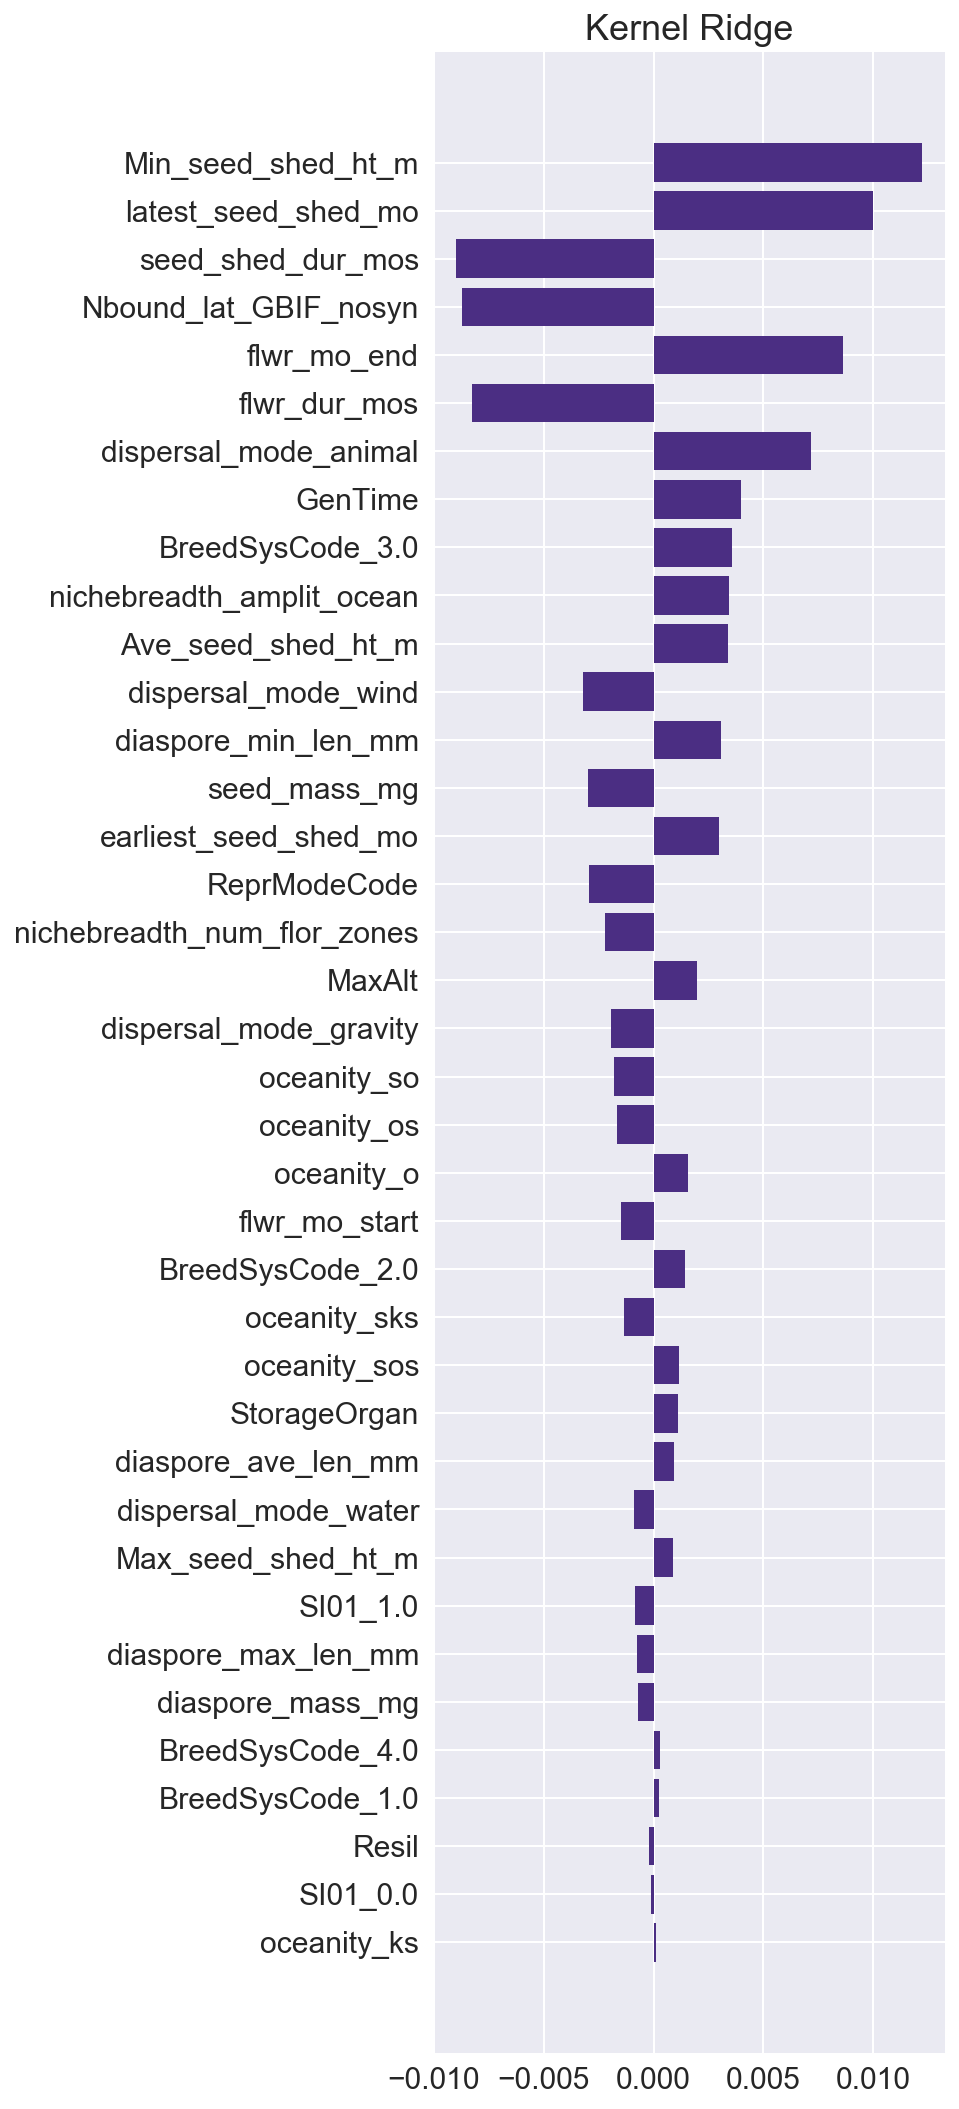

In [12]:
mean_error = np.mean(kernel_ridge_mses)
std_error = np.std(kernel_ridge_mses)
mean_coefs = np.mean(kernel_ridge_coefs, axis=0)
std_coefs = np.std(kernel_ridge_coefs, axis=0)
plot_importance(mean_coefs, td.feature_names, "Kernel Ridge", 
               save="{}_kernelridge-ranks.png".format(join(results_dir, dsname)))#, std=std_coefs)
MSEs.append(("Kernel Ridge", kernel_ridge_mses))
COEFs.append(("Kernel Ridge", mean_coefs))
rankings.append(['Kernel Ridge'] + list(compute_ranks(mean_coefs)))

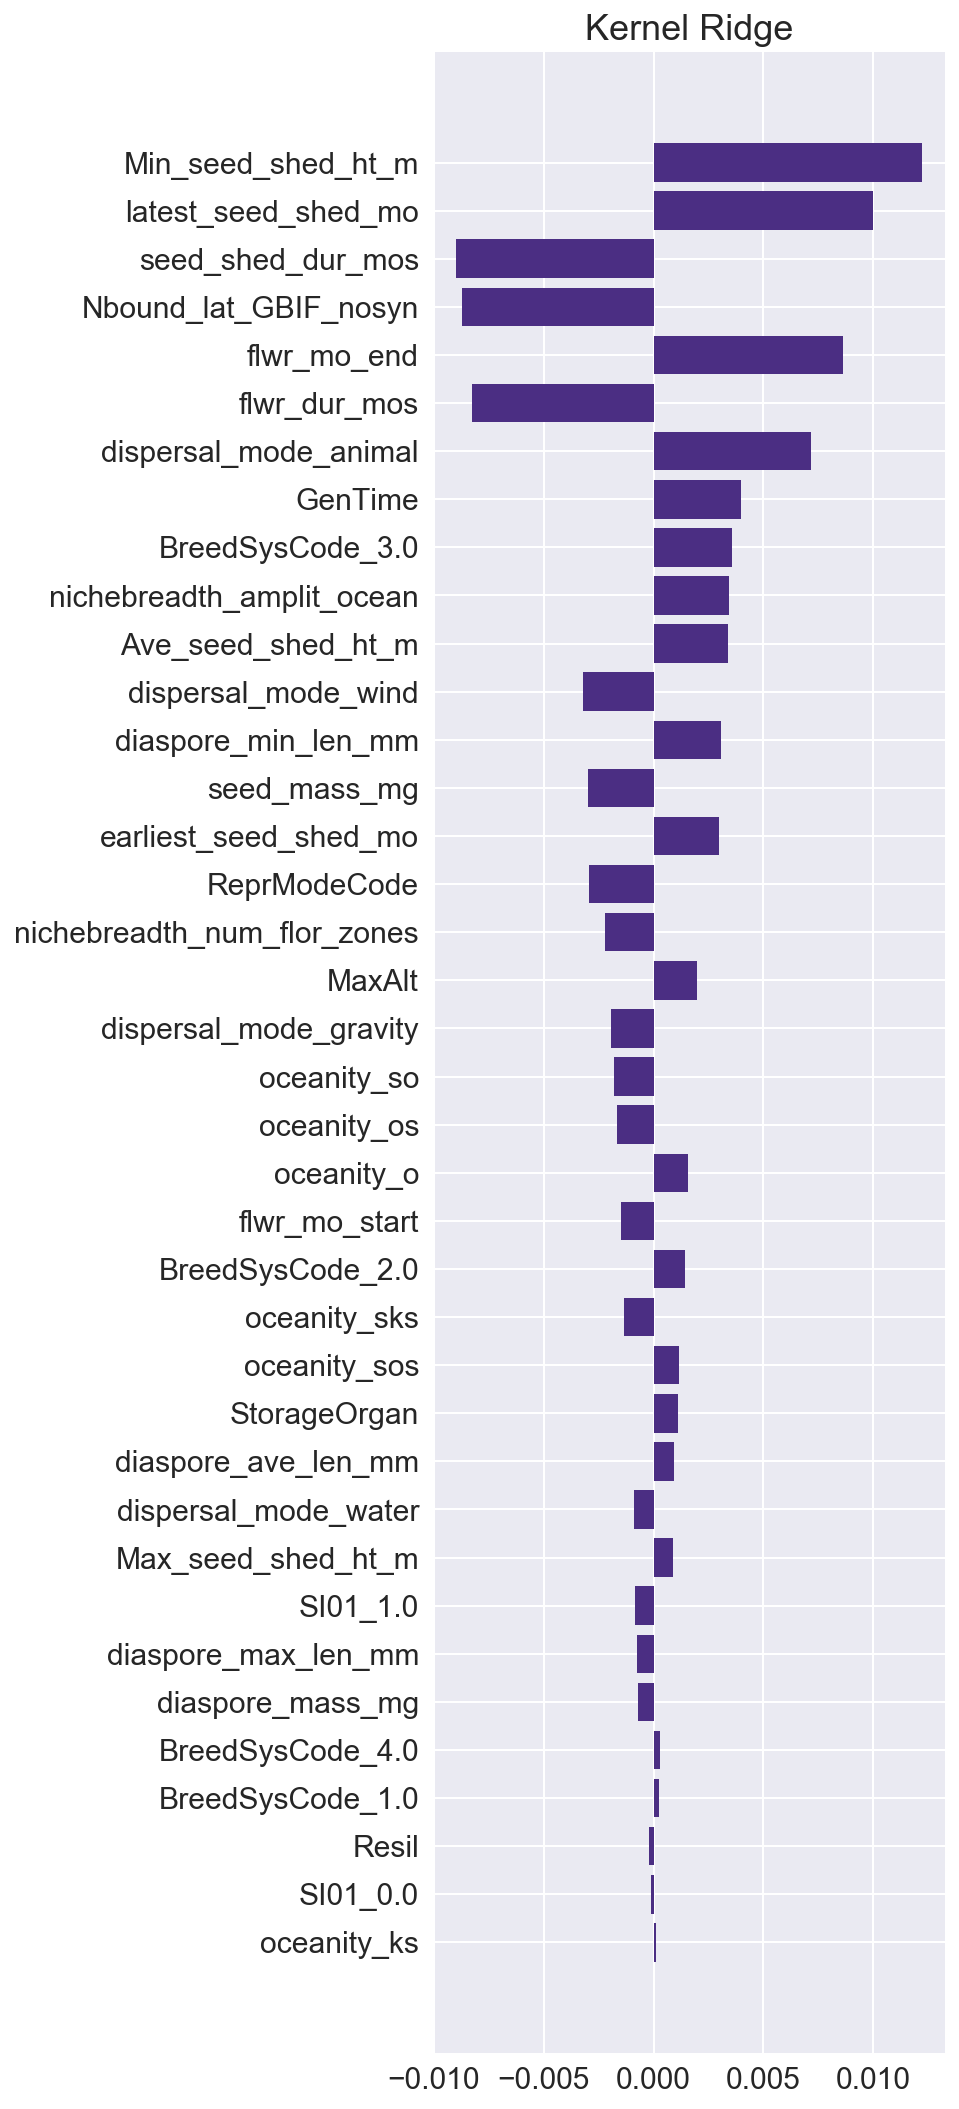

In [13]:
plot_importance(mean_coefs,
                td.feature_names,
                "Kernel Ridge", save="{}_kernelridge-nostd-ranks.png".format(join(results_dir,dsname)))
                #std=std_coefs)

rankings.append(['Kernel Ridge'] + list(compute_ranks(mean_coefs)))

### Trees

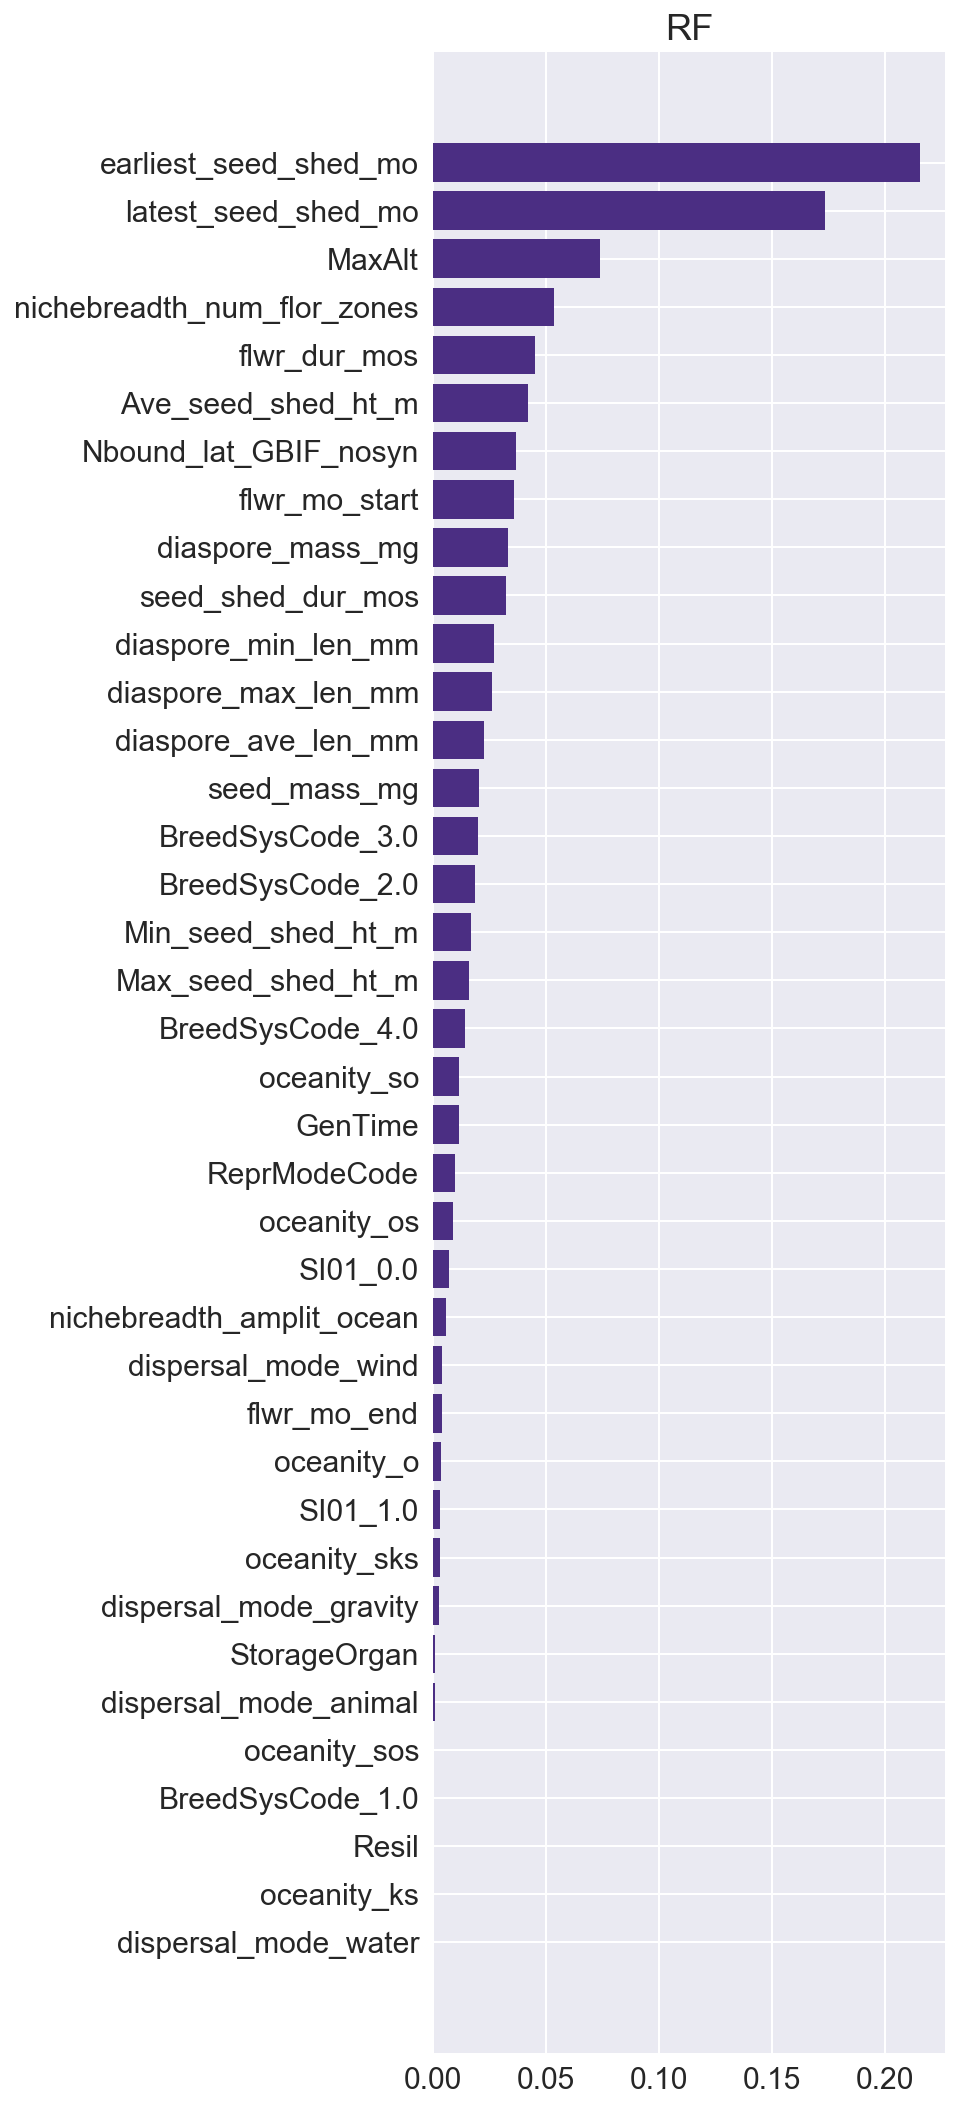

In [14]:
rf_coefs = []
rf_mses = []
for train, test in cv.split(td.X, td.Y):    
    rf = RandomForestRegressor()
    rf.fit(td.X[train], td.Y[train])
    preds = rf.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    rf_mses.append(error)
    rf_coefs.append(rf.feature_importances_)

mean_error = np.mean(rf_mses)
std_error = np.std(rf_mses)
mean_coefs = np.mean(rf_coefs, axis=0)
std_coefs = np.std(rf_coefs, axis=0)
    
MSEs.append(("RF", rf_mses))
COEFs.append(("RF", mean_coefs))
plot_importance(mean_coefs,
                td.feature_names, "RF",
                save="{}_rf-ranks.png".format(join(results_dir,dsname)))
rankings.append(['RF'] + list(compute_ranks(rf.feature_importances_)))

### Support Vectors

In [15]:
baseModel = SVR()
params_grid = {
    'C'     : np.logspace(-3, 1.2),
    'gamma' : np.logspace(-3, 1.2),
    'degree': [0, 1, 2],
    'kernel': ['linear', 'poly', 'rbf']
}
gridSearch = GridSearchCV(baseModel,
                         param_grid = params_grid,
                         scoring="neg_mean_squared_error",
                         error_score = 0,
                         n_jobs = -1)

svr_coefs = []
svr_mses = []



for train, test in list(cv.split(td.X, td.Y)):   
    print("CV Run Init")
    gridSearch.fit(td.X[train], td.Y[train])
    best = gridSearch.best_estimator_
    preds = gridSearch.best_estimator_.predict(td.X[test])
    error = mean_squared_error(preds, td.Y[test])
    svr_mses.append(error)
    try:
        shapdata = shap.DenseData(td.X[train], td.feature_names) 
        explainer = shap.KernelExplainer(best.predict, shapdata, nsamples=100)
        svr_coefs.append(explainer.explain(np.mat(td.X[test])).effects)
    except Exception as e:
        print("error in SHAP, continuing")
        continue


CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
error in SHAP, continuing
CV Run Init
CV Run Init
CV Run Init


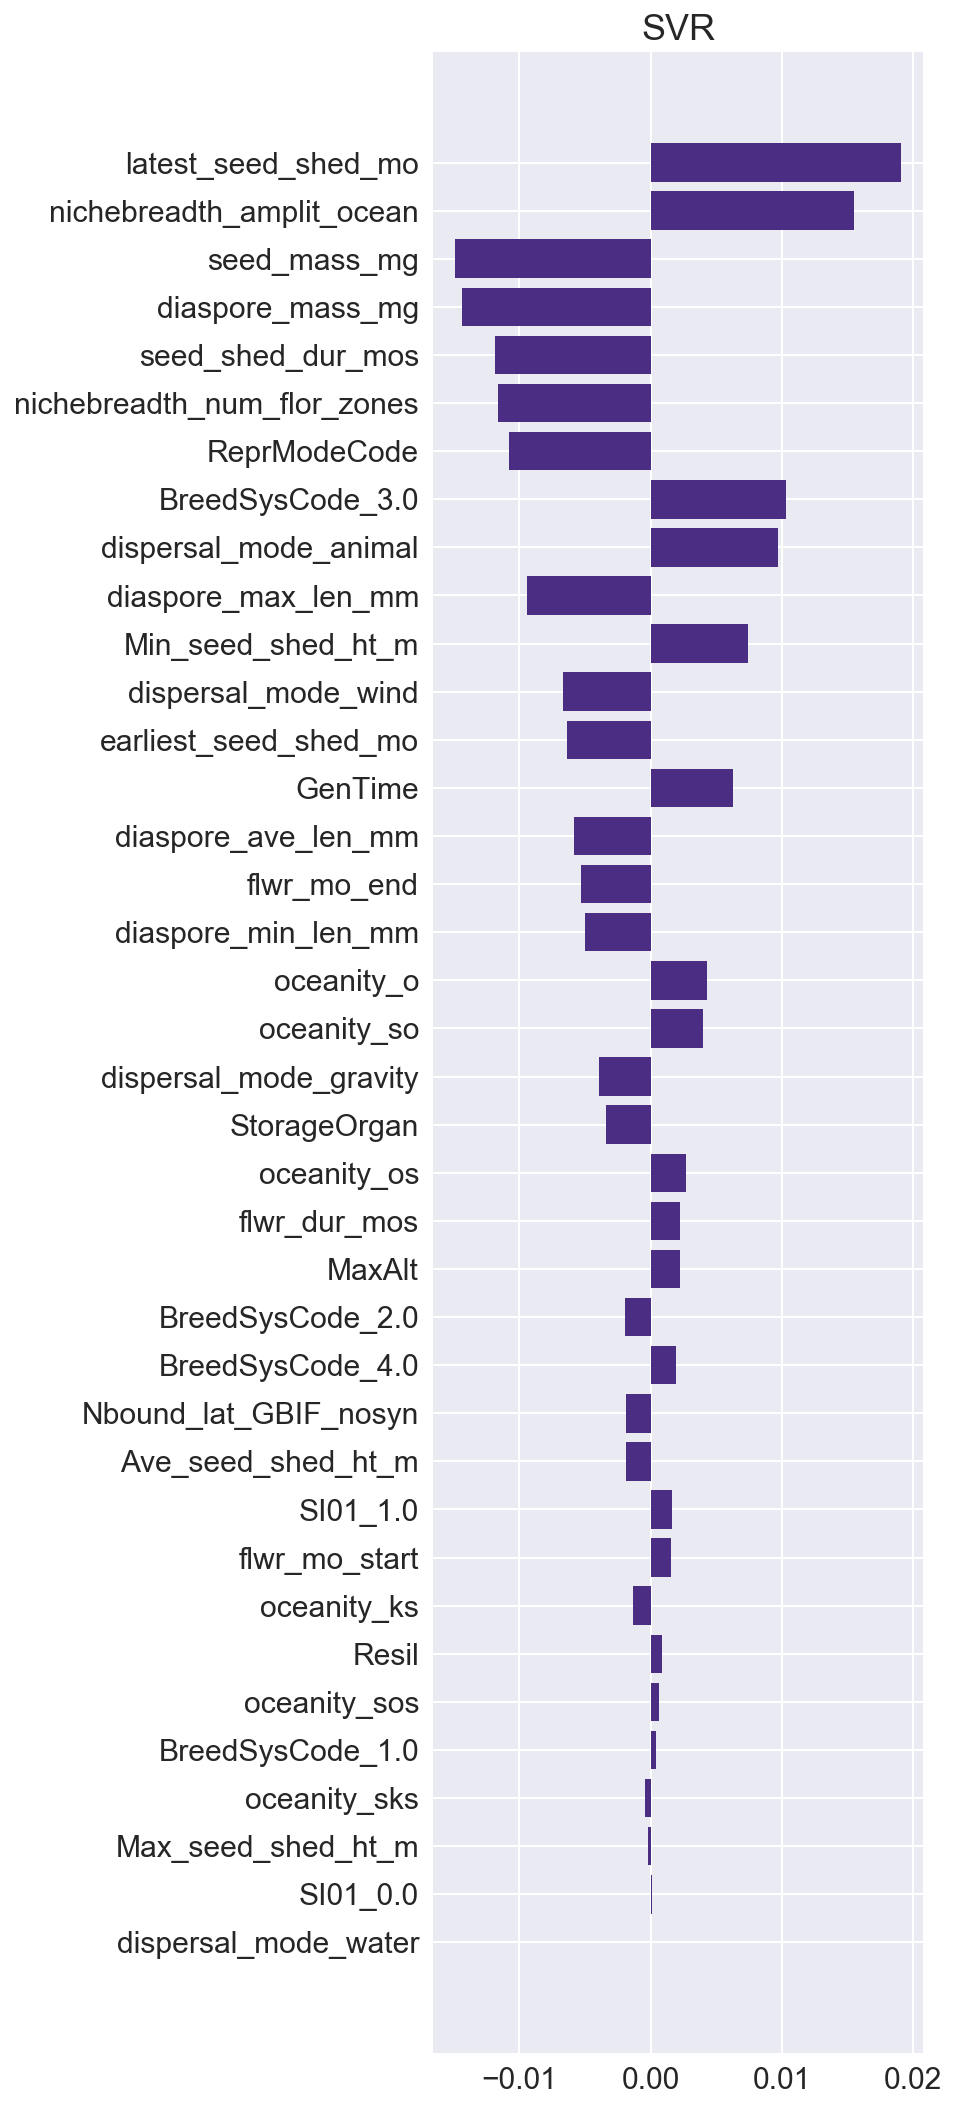

In [16]:
mean_error = np.mean(svr_mses)
std_error = np.std(svr_mses)
mean_coefs = np.mean(svr_coefs, axis=0)
std_coefs = np.std(svr_coefs, axis=0)




MSEs.append(("SVR", svr_mses))
COEFs.append(("SVR", mean_coefs))
plot_importance(mean_coefs,
                td.feature_names, "SVR",
                save="{}_svr-ranks.png".format(join(results_dir, dsname)))
rankings.append(['SVR'] + list(compute_ranks(mean_coefs)))

In [17]:
results = pd.DataFrame(rankings, columns=["Method"] + td.feature_names).set_index("Method").T
results['mean'] = results.mean(axis=1)


AssertionError: 39 columns passed, passed data had 10661 columns

In [ ]:
results.sort_values(by=['mean'])

In [ ]:
results.sort_values(by=['mean'])


In [ ]:
results.to_csv("{}-rank.csv".format(dsname))
from pandas.tools.plotting import table


In [ ]:
results = results.sort_values(by='mean')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
tab = table(ax, results, loc='upper left')
tab.auto_set_font_size(False)
tab.set_fontsize(14)
tab.scale(1.2, 1.3)
fig.tight_layout()

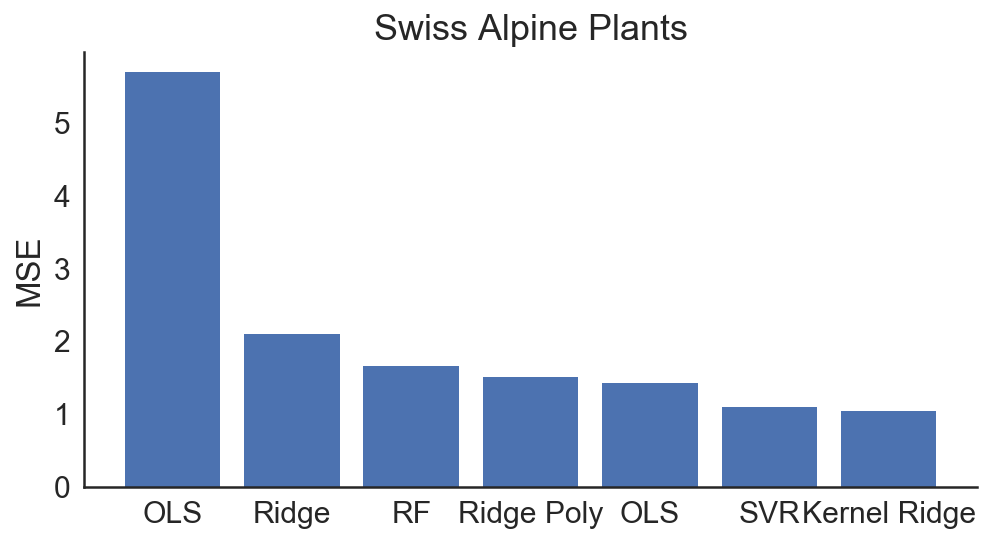

In [18]:
sns.set(style="white", font_scale=1.5)
fig = plt.figure(figsize=(8, 4))
labels, errors = zip(*MSEs)
errors = np.array(errors)
error_means = np.mean(errors, axis=1)
error_stds = np.std(errors, axis=1)
labels = np.array(labels)
sorted_idx = np.argsort(error_means)[::-1]
plt.bar(range(0, len(MSEs)), error_means[sorted_idx])#, yerr=error_stds)
plt.xticks(range(0, len(MSEs)), labels[sorted_idx])
plt.ylabel("MSE")
plt.title(dataset['name'])
sns.despine()
plt.savefig("{}-msecompare.png".format(join(results_dir, dsname)), dpi=200)


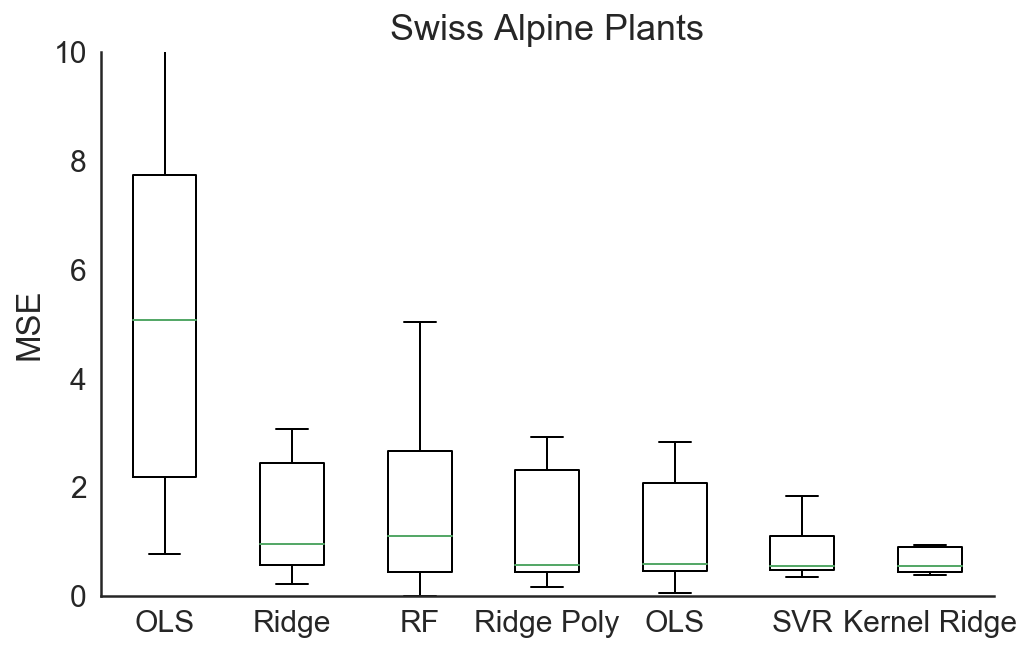

In [19]:
sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(8,5))
plt.boxplot(errors[sorted_idx].T)
plt.xticks(range(1, len(MSEs) +1), labels[sorted_idx])
plt.ylim(0, 10)
plt.ylabel("MSE")
plt.title(dataset['name'])
sns.despine()
plt.savefig("{}-msecompare-boxplot.png".format(join(results_dir, dsname)), dpi=200)



### Save Mean Coefficients 

In [ ]:
coefs_df = pd.DataFrame(dict(COEFs))
coefs_df['trait'] = td.feature_names
cols = coefs_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
coefs_df = coefs_df[cols]
# sort by mean rank
coefs_df.set_index('trait').loc[results.index].reset_index()
coefs_df.to_csv("{}-coefs.csv".format(join(results_dir, dsname)), index=False)

In [ ]:
coefs_df

### Save MSEs 


In [ ]:
pd.DataFrame(MSEs, columns=["method", "MSEs"]).to_csv("{}-mseraw.csv".format(join(results_dir, dsname)))